In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import qiskit
import numpy as np

from PatchedMeasCal.tensor_patch_cal import TensorPatchFitter
from PatchedMeasCal.inv_measure_methods import aim, sim
from PatchedMeasCal.jigsaw import jigsaw
from PatchedMeasCal.qiskit_meas_fitters import qiskit_full, qiskit_linear


from PatchedMeasCal.fake_backends import LocalSimulator


from PatchedMeasCal import state_prep_circuits
from PatchedMeasCal.fake_measurement_distributions import renormalise_measurement_results
from PatchedMeasCal.utils import Progressbar

from PatchedMeasCal.fake_backends import Grid, Hexagonal16, FullyConnected

from PatchedMeasCal.state_prep_circuits import GHZ_prep, GHZ_state_dist
from PatchedMeasCal.bv import bv_circuit_cmap


from qiskit import Aer, execute, QuantumCircuit
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

from functools import partial

import qiskit.tools.jupyter

import mthree

import random

qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider()

%qiskit_job_watcher

ibmqfactory.load_account:WARNING:2023-03-01 21:37:12,613: Credentials are already in use. The existing account in the session will be replaced.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

## Setup
The idea here is that each approachs gets a maximum of 32000 measurement shots to spend
- Backend style methods will spend 50% of that on the build, 50% of that on the run
- Circuit style methods will spend 50% on their full run, and the other 50% on other circuits that need to be exectued
- AIM will divide theirs up evenly

In [11]:
n_qubits = 7
n_meas_shots = 16000
n_build_shots = 16000
n_shots_qiskit_full = n_build_shots // (2 ** n_qubits) 
n_shots_qiskit_partial = n_build_shots // (n_qubits)


n_circuit_method_shots = n_meas_shots + n_build_shots
backend = provider.get_backend('ibm_nairobi')

n_shots_cmc = n_build_shots // (2 * len(backend.configuration().coupling_map))

err_cmap = [[0, 6], [3, 6], [4, 6], [0, 2], [1, 2], [2, 5], [2, 6]]

## Mitigation Methods Build

In [14]:
# full_filter = qiskit_full(backend, n_qubits, n_shots_qiskit_full)

# # n Circuits to execute
# linear_filter = qiskit_linear(backend, n_qubits, n_shots_qiskit_partial)



# mit = mthree.M3Mitigation(backend)
# mit.cals_from_system(list(range(n_qubits)), n_build_shots // 2)

tpf_err = TensorPatchFitter(backend, n_shots=n_shots_cmc, coupling_map=err_cmap)
tpf_err.build(verbose=True)

tpf = TensorPatchFitter(backend, n_shots=n_shots_cmc)
tpf.build(verbose=True)

Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits


ERROR:websocket:error from callback <bound method BaseWebsocketClient.on_close of <qiskit.providers.ibmq.api.clients.websocket.WebsocketClient object at 0x7fa4791c0d30>>: on_close() missing 2 required positional arguments: 'status_code' and 'msg'
ERROR:websocket:error from callback <bound method BaseWebsocketClient.on_close of <qiskit.providers.ibmq.api.clients.websocket.WebsocketClient object at 0x7fa4791c0d30>>: on_close() missing 2 required positional arguments: 'status_code' and 'msg'


	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits


ERROR:websocket:close status: 4002


	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s


## Run with repetitions
If everything above is working, let's crank it out a few times

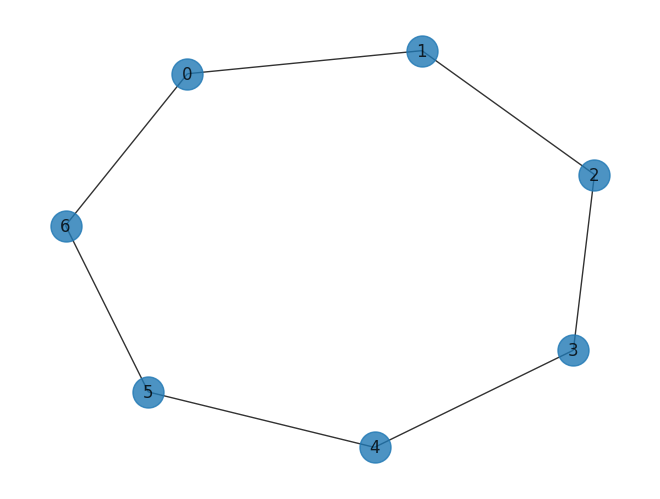

In [15]:
G = nx.Graph()
G.add_nodes_from(list(range(n_qubits)))
G.add_edges_from([(i, (i + 1) % n_qubits) for i in list(range(n_qubits))])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

Qiskit QAOA Code

In [27]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta, backend=backend):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qiskit.transpile(qc, backend=backend)

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, *args, **kwargs):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """    
    def execute_circ(theta, *args, backend=None, mitigation=None, execution=None, **kwargs):
        qc = create_qaoa_circ(G, theta, backend=backend)
        if execution is None:
            counts = backend.run(qc, *args, **kwargs).result().get_counts()
        else:
            counts = execution(qc, *args, **kwargs)
            
        if mitigation is not None:
            counts = mitigation(counts, *args, **kwargs)
        
        return compute_expectation(counts, G)
    
    return partial(execute_circ, *args, **kwargs)

In [26]:
target_val = 0
n_trials = 1000
expectation = get_expectation(G, backend=LocalSimulator(n_qubits))
for i in range(n_trials):
    target_val += expectation([1.0, 1.0])
target_val /= n_trials
print(target_val)

def distance_measure_base(x, target_val):
    return abs(x - target_val)
dist_measure = lambda x: distance_measure_base(x, target_val)


-2.49941015625


In [30]:
n_reps = 10
results = {
    'bare':[],
    'full':[],
    'linear':[],
    'aim':[],
    'sim':[],
    'jigsaw':[],
    'cmc':[],
    'cmc_err':[],
    'm3':[]
}


aim_l = lambda circ: aim(circ, backend, n_qubits, n_shots=n_circuit_method_shots, equal_shot_distribution=True)
sim_l = lambda circ: sim(circ, backend, n_qubits, n_shots=n_circuit_method_shots, equal_shot_distribution=True)
jigsaw_l = lambda circ: jigsaw(circ, backend, n_circuit_method_shots, equal_shot_distribution=True)
mit_apply = lambda x: mit.apply_correction(x, list(range(n_qubits))).nearest_probability_distribution()

for _ in range(n_reps):

    expectation = get_expectation(G, backend=backend)
    res = expectation([1.0, 1.0]) 
    results['bare'].append(
        dist_measure(res)
    )
    
#     expectation = get_expectation(G, backend=backend, mitigation=full_filter.apply)
#     res = expectation([1.0, 1.0]) 
#     results['full'].append(
#         dist_measure(res)
#     )
   
#     expectation = get_expectation(G, backend=backend, mitigation=linear_filter.apply)
#     res = expectation([1.0, 1.0]) 
#     results['linear'].append(
#         dist_measure(res)
#     )
    
    expectation = get_expectation(G, backend=backend, mitigation=tpf.apply)
    res = expectation([1.0, 1.0]) 
    results['cmc'].append(
        dist_measure(res)
    )
    
    expectation = get_expectation(G, backend=backend, mitigation=tpf_err.apply)
    res = expectation([1.0, 1.0]) 
    results['cmc_err'].append(
        dist_measure(res)
    )
    
    
    expectation = get_expectation(G, backend=backend, mitigation=mit_apply)
    res = expectation([1.0, 1.0]) 
    results ['m3'].append(
        dist_measure(res)
    )
                                               
    expectation = get_expectation(G, backend=backend, execution=sim_l)
    res = expectation([1.0, 1.0]) 
    results['sim'].append(
        dist_measure(res)
    )
    
    expectation = get_expectation(G, backend=backend, execution=aim_l)
    res = expectation([1.0, 1.0]) 
    results['aim'].append(
        dist_measure(res)
    )
                                               
    expectation = get_expectation(G, backend=backend, execution=jigsaw_l)
    res = expectation([1.0, 1.0]) 
    results['jigsaw'].append(
        dist_measure(res)
    )

ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:clos

In [31]:
results

{'bare': [0.7805898437499996,
  0.80558984375,
  0.7820898437499997,
  0.9010898437499999,
  0.87608984375,
  0.7305898437499998,
  0.7465898437499998,
  0.7740898437499997,
  0.6800898437499998,
  0.6710898437499999],
 'full': [],
 'linear': [],
 'aim': [0.8581731770833332,
  0.8644231770833333,
  0.9179231770833329,
  0.8117565104166666,
  0.8315065104166663,
  0.856923177083333,
  0.8102565104166666,
  0.8829231770833332,
  0.8306731770833333,
  0.8508398437499998],
 'sim': [0.8734648437499999,
  0.9224648437499998,
  0.8918398437499997,
  0.8569648437499997,
  0.9486523437499996,
  0.83208984375,
  0.79071484375,
  0.8934023437499996,
  0.8409648437499997,
  0.7902773437499997],
 'jigsaw': [0.7144895847373536,
  0.9228091112083239,
  0.9733812857603525,
  0.7412531668317106,
  0.7425053110160484,
  0.903191681274718,
  0.6279711926998726,
  0.8032794611890841,
  0.7731135437722445,
  0.6606040746303665],
 'cmc': [0.9015804686975959,
  0.7595200150587753,
  0.758957491990222,
  0.80

In [35]:
qaoa_nairobi_results = {'bare': [0.7805898437499996,
  0.80558984375,
  0.7820898437499997,
  0.9010898437499999,
  0.87608984375,
  0.7305898437499998,
  0.7465898437499998,
  0.7740898437499997,
  0.6800898437499998,
  0.6710898437499999],
 'aim': [0.8581731770833332,
  0.8644231770833333,
  0.9179231770833329,
  0.8117565104166666,
  0.8315065104166663,
  0.856923177083333,
  0.8102565104166666,
  0.8829231770833332,
  0.8306731770833333,
  0.8508398437499998],
 'sim': [0.8734648437499999,
  0.9224648437499998,
  0.8918398437499997,
  0.8569648437499997,
  0.9486523437499996,
  0.83208984375,
  0.79071484375,
  0.8934023437499996,
  0.8409648437499997,
  0.7902773437499997],
 'jigsaw': [0.7144895847373536,
  0.9228091112083239,
  0.9733812857603525,
  0.7412531668317106,
  0.7425053110160484,
  0.903191681274718,
  0.6279711926998726,
  0.8032794611890841,
  0.7731135437722445,
  0.6606040746303665],
 'cmc': [0.9015804686975959,
  0.7595200150587753,
  0.758957491990222,
  0.803348192141883,
  0.7555316032641777,
  0.786642603251221,
  0.818520152910279,
  0.7244187166842218,
  0.6161562780101275,
  0.7950625697184326],
 'cmc_err': [0.9066462393161814,
  0.8006393814646375,
  0.7247790095137221,
  0.8171850889139667,
  0.8332604301081377,
  0.7796452419770552,
  0.7950411433527869,
  0.6141037275118406,
  0.6556588402795045,
  0.767304857718202],
 'm3': [0.7557260241810173,
  0.8260023767266778,
  0.6358291775801002,
  0.6725471175346147,
  0.7106896045130724,
  0.7174555490883443,
  0.7415781396343633,
  0.6675493611738093,
  0.6695254597866507,
  0.5909465852442506]}

In [36]:
res = qaoa_nairobi_results
for r in res:
    avg = np.mean(res[r])
    h_bound = np.max(res[r]) - avg
    l_bound = avg - np.min(res[r])
    print(r, " & ", "$", "%.2f" % avg, "\substack{+", "%.2f" % h_bound, " \\\\ -", "%.2f" %l_bound, "}$", sep='')

bare & $0.77\substack{+0.13 \\ -0.10}$
aim & $0.85\substack{+0.07 \\ -0.04}$
sim & $0.86\substack{+0.08 \\ -0.07}$
jigsaw & $0.79\substack{+0.19 \\ -0.16}$
cmc & $0.77\substack{+0.13 \\ -0.16}$
cmc_err & $0.77\substack{+0.14 \\ -0.16}$
m3 & $0.70\substack{+0.13 \\ -0.11}$
